# Accuracy vs Cue Following Correlation 


In [ ]:
!pip install seaborn
!pip install scipy

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datasets import load_dataset
from hf_utils import load_hf_as_df

In [44]:

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [45]:
print("Loading summary datasets...")
df_cue_summary = load_hf_as_df("yulia-volkova/mmlu-chua-cue-summary")
df_base_summary = load_hf_as_df("yulia-volkova/mmlu-chua-base-summary")

print(f"Loaded {len(df_cue_summary)} problems from cue summary")
print(f"Loaded {len(df_base_summary)} problems from base summary")


# Merge base and cue summaries on pi
df_merged = pd.merge(
    df_base_summary[["pi", "accuracy", "cue_match", "gt_match"]].rename(
        columns={"accuracy": "accuracy_base", "cue_match": "cue_match_base", "gt_match": "gt_match_base"}
    ),
    df_cue_summary[["pi", "accuracy", "cue_match", "gt_match"]].rename(
        columns={"accuracy": "accuracy_cue", "cue_match": "cue_match_cue", "gt_match": "gt_match_cue"}
    ),
    on="pi",
    how="inner",
)


# Compute cue_response_gap
df_merged["cue_response_gap"] = df_merged["cue_match_cue"] - df_merged["cue_match_base"]

# Compute accuracy difference
df_merged["accuracy_diff"] = df_merged["accuracy_cue"] - df_merged["accuracy_base"]

print(f"\nFinal merged dataset: {len(df_merged)} problems")
print(f"Columns: {list(df_merged.columns)}")


Loading summary datasets...
Loaded 143 problems from cue summary
Loaded 143 problems from base summary

Final merged dataset: 143 problems
Columns: ['pi', 'accuracy_base', 'cue_match_base', 'gt_match_base', 'accuracy_cue', 'cue_match_cue', 'gt_match_cue', 'cue_response_gap', 'accuracy_diff']


Want to check if problems where the model initially had lower accuracy are more susceptible to cue following.


In [54]:
# Check which problems have NaN values
df_nan_base = df_merged[df_merged["accuracy_base"].isna()][["pi", "accuracy_base"]]

print(f"Found {len(df_nan_base)} problems with NaN accuracy_base")
df_nan_base = df_nan_base.reset_index(drop=True)
print(df_nan_base.head())



Found 1 problems with NaN accuracy_base
   pi  accuracy_base
0  49            NaN


In [55]:
# Bin problems by base accuracy
df_merged["accuracy_base_bin"] = pd.cut(
    df_merged["accuracy_base"],
    bins=5,
    labels=["Very Low (0-0.2)", "Low (0.2-0.4)", "Medium (0.4-0.6)", "High (0.6-0.8)", "Very High (0.8-1.0)"]
)

# Group by accuracy bin and compute statistics
binned_stats = df_merged.groupby("accuracy_base_bin").agg({
    "cue_response_gap": ["mean", "std", "count"],
    "cue_match_cue": ["mean", "std"],
    "cue_match_base": ["mean", "std"],
    "accuracy_base": ["mean", "std"],
    "accuracy_cue": ["mean", "std"],
}).round(3)

print("Statistics by Base Accuracy Level:")
print(binned_stats)


Statistics by Base Accuracy Level:
                    cue_response_gap              cue_match_cue         \
                                mean    std count          mean    std   
accuracy_base_bin                                                        
Very Low (0-0.2)               0.211  0.239    34         0.646  0.377   
Low (0.2-0.4)                  0.384  0.161    22         0.638  0.292   
Medium (0.4-0.6)               0.295  0.328    13         0.484  0.331   
High (0.6-0.8)                 0.416  0.251    19         0.562  0.330   
Very High (0.8-1.0)            0.252  0.274    54         0.261  0.283   

                    cue_match_base        accuracy_base        accuracy_cue  \
                              mean    std          mean    std         mean   
accuracy_base_bin                                                             
Very Low (0-0.2)             0.435  0.397         0.077  0.068        0.052   
Low (0.2-0.4)                0.254  0.246         0.321 

/var/folders/vg/1dvt1w6x4dxfj0lf2f48nphc0000gn/T/ipykernel_50571/770654646.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_stats = df_merged.groupby("accuracy_base_bin").agg({


/var/folders/vg/1dvt1w6x4dxfj0lf2f48nphc0000gn/T/ipykernel_50571/3908794307.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_gap = df_merged.groupby("accuracy_base_bin")["cue_response_gap"].mean()
/var/folders/vg/1dvt1w6x4dxfj0lf2f48nphc0000gn/T/ipykernel_50571/3908794307.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_cue_follow = df_merged.groupby("accuracy_base_bin")["cue_match_cue"].mean()


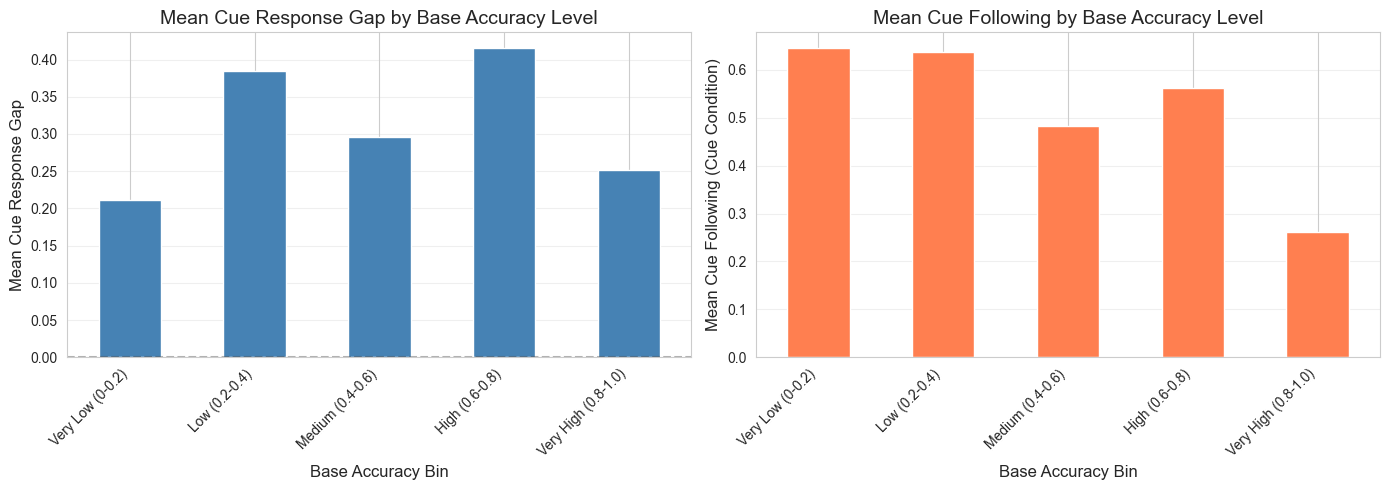

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Cue Response Gap by base accuracy bin
ax1 = axes[0]
binned_gap = df_merged.groupby("accuracy_base_bin")["cue_response_gap"].mean()
binned_gap.plot(kind="bar", ax=ax1, color="steelblue")
ax1.set_xlabel("Base Accuracy Bin", fontsize=12)
ax1.set_ylabel("Mean Cue Response Gap", fontsize=12)
ax1.set_title("Mean Cue Response Gap by Base Accuracy Level", fontsize=14)
ax1.grid(True, alpha=0.3, axis="y")
ax1.axhline(y=0, color="k", linestyle="--", alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha="right")

# 2. Cue Following (absolute) by base accuracy bin
ax2 = axes[1]
binned_cue_follow = df_merged.groupby("accuracy_base_bin")["cue_match_cue"].mean()
binned_cue_follow.plot(kind="bar", ax=ax2, color="coral")
ax2.set_xlabel("Base Accuracy Bin", fontsize=12)
ax2.set_ylabel("Mean Cue Following (Cue Condition)", fontsize=12)
ax2.set_title("Mean Cue Following by Base Accuracy Level", fontsize=14)
ax2.grid(True, alpha=0.3, axis="y")
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [ ]:
df_corr1 = df_merged[["accuracy_base", "cue_response_gap"]].dropna()
df_corr2 = df_merged[["accuracy_base", "cue_match_cue"]].dropna()

print(f"Data points for correlation 1: {len(df_corr1)} (out of {len(df_merged)})")
print(f"Data points for correlation 2: {len(df_corr2)} (out of {len(df_merged)})")

corr_base_acc_gap = df_corr1["accuracy_base"].corr(df_corr1["cue_response_gap"])
print(f"\nCorrelation: accuracy_base vs cue_response_gap = {corr_base_acc_gap:.3f}")

corr_base_acc_cue_follow = df_corr2["accuracy_base"].corr(df_corr2["cue_match_cue"])
print(f"Correlation: accuracy_base vs cue_match_cue = {corr_base_acc_cue_follow:.3f}")

print("\nStatistical significance tests:")

def format_pvalue(p):
    """Format p-value with appropriate precision."""
    if p < 0.0001:
        return f"{p:.2e}" 
    elif p < 0.001:
        return f"{p:.6f}"
    else:
        return f"{p:.4f}"

if len(df_corr1) > 2 and df_corr1["accuracy_base"].var() > 0 and df_corr1["cue_response_gap"].var() > 0:
    pearson_base_acc_gap = stats.pearsonr(df_corr1["accuracy_base"], df_corr1["cue_response_gap"])
    p_val1 = format_pvalue(pearson_base_acc_gap[1])
    print(f"  Base accuracy vs cue_response_gap: r={pearson_base_acc_gap[0]:.3f}, p={p_val1}")
else:
    print(f"  Base accuracy vs cue_response_gap: Cannot compute (insufficient variance or data)")

if len(df_corr2) > 2 and df_corr2["accuracy_base"].var() > 0 and df_corr2["cue_match_cue"].var() > 0:
    pearson_base_acc_cue = stats.pearsonr(df_corr2["accuracy_base"], df_corr2["cue_match_cue"])
    p_val2 = format_pvalue(pearson_base_acc_cue[1])
    print(f"  Base accuracy vs cue_match_cue: r={pearson_base_acc_cue[0]:.3f}, p={p_val2}")
else:
    print(f"  Base accuracy vs cue_match_cue: Cannot compute (insufficient variance or data)")

print("\nInterpretation:")
if corr_base_acc_gap < 0:
    print(f"  Negative correlation ({corr_base_acc_gap:.3f}): Lower base accuracy → MORE cue following")
else:
    print(f"  Positive correlation ({corr_base_acc_gap:.3f}): Lower base accuracy → LESS cue following")


Data points for correlation 1: 142 (out of 143)
Data points for correlation 2: 142 (out of 143)

Correlation: accuracy_base vs cue_response_gap = 0.008
Correlation: accuracy_base vs cue_match_cue = -0.459

Statistical significance tests:
  Base accuracy vs cue_response_gap: r=0.008, p=0.9231
  Base accuracy vs cue_match_cue: r=-0.459, p=9.00e-09

Interpretation:
  Positive correlation (0.008): Lower base accuracy → LESS cue following


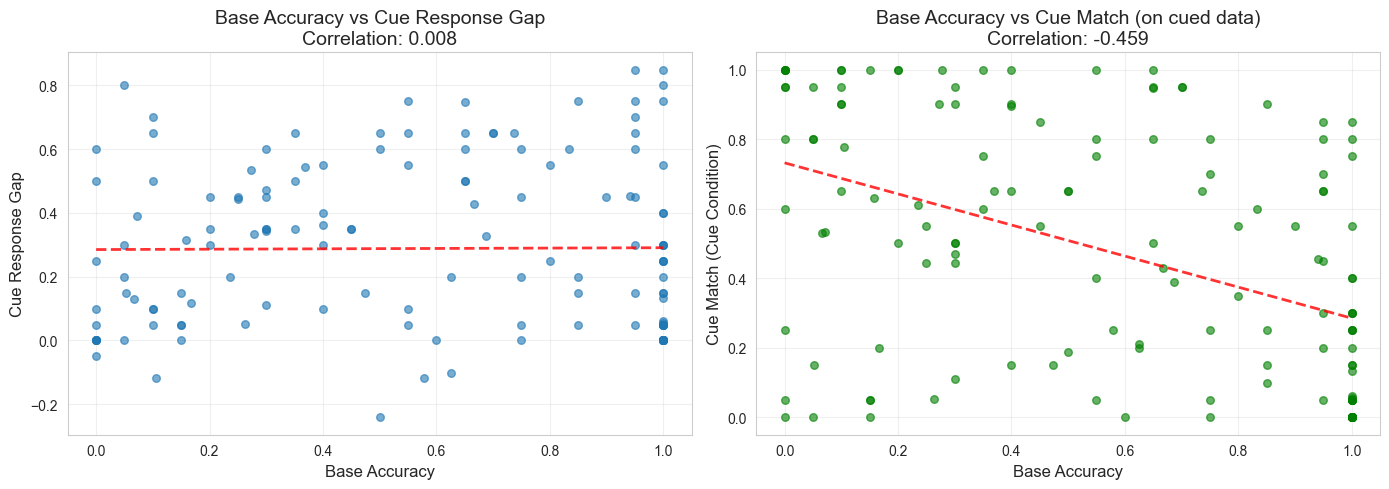

In [59]:
# Create figure with subplots (using filtered data from diagnostic cell)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Base accuracy vs Cue Response Gap
ax1 = axes[0]
ax1.scatter(df_valid1["accuracy_base"], df_valid1["cue_response_gap"], alpha=0.6, s=30)
ax1.set_xlabel("Base Accuracy", fontsize=12)
ax1.set_ylabel("Cue Response Gap", fontsize=12)
ax1.set_title(f"Base Accuracy vs Cue Response Gap\nCorrelation: {corr_base_acc_gap:.3f}", fontsize=14)
ax1.grid(True, alpha=0.3)

# Add trend line (with error handling)
try:
    if len(df_valid1) > 1 and df_valid1["accuracy_base"].var() > 1e-10:
        z = np.polyfit(df_valid1["accuracy_base"], df_valid1["cue_response_gap"], 1)
        p = np.poly1d(z)
        x_sorted = np.sort(df_valid1["accuracy_base"])
        ax1.plot(x_sorted, p(x_sorted), "r--", alpha=0.8, linewidth=2)
    else:
        print("Warning: Insufficient variance for trend line (plot 1)")
except (np.linalg.LinAlgError, ValueError) as e:
    print(f"Warning: Could not fit trend line for plot 1: {e}")

# 2. Base accuracy vs Absolute Cue Following (in cue condition)
ax2 = axes[1]
ax2.scatter(df_valid2["accuracy_base"], df_valid2["cue_match_cue"], alpha=0.6, s=30, color="green")
ax2.set_xlabel("Base Accuracy", fontsize=12)
ax2.set_ylabel("Cue Match (Cue Condition)", fontsize=12)
ax2.set_title(f"Base Accuracy vs Cue Match (on cued data)\nCorrelation: {corr_base_acc_cue_follow:.3f}", fontsize=14)
ax2.grid(True, alpha=0.3)

# Add trend line (with error handling)
try:
    if len(df_valid2) > 1 and df_valid2["accuracy_base"].var() > 1e-10:
        z = np.polyfit(df_valid2["accuracy_base"], df_valid2["cue_match_cue"], 1)
        p = np.poly1d(z)
        x_sorted = np.sort(df_valid2["accuracy_base"])
        ax2.plot(x_sorted, p(x_sorted), "r--", alpha=0.8, linewidth=2)
    else:
        print("Warning: Insufficient variance for trend line (plot 2)")
except (np.linalg.LinAlgError, ValueError) as e:
    print(f"Warning: Could not fit trend line for plot 2: {e}")

plt.tight_layout()
plt.show()
